## Trying to build a Riemann solver by hand to work with Burgers' equation in 1D

In this Notebook we are going to use the **MacCormack method** to solve the Burgers' inviscid equation in 1D, which states as follows:

$$
\frac{\partial u}{\partial t}+\frac{\partial\left(\frac{1}{2}u^{2}\right)}{\partial x}=0,
$$

where $u(t,x)$ is a certain field. We are going to consider the following initial conditions:

$$
u(0,x)\equiv u_{0}(x)=\left\{
\begin{array}{ll}
      1, & x\leq 0 \\
      0, & x>0 \\
\end{array} 
\right.,
$$

with the discretization:

$$
t\in[0,1],\:\:\:x\in[-1,1],
$$

ant therefore we will have an initial discontinuity at $x=0$.

Without making use of the explicit Jacobian, one can compute the solution for a higher time given the solution in a previous temporal point using the following numerical scheme of 2 steps called **MacCormack method**.

First step, compute:

$$
U_{j}^{*}=U_{j}^{n}-\frac{\Delta t}{\Delta x}\left[f(u_{j+1}^{n})-f(u_{j}^{n})\right],
$$

where $f$ corresponds to the flux. Second step:

$$
U_{j}^{n+1}=\frac{1}{2}(U_{j}^{n}+U_{j}^{*})-\frac{\Delta t}{2\Delta x}\left[f(U_{j}^{*})-f(U_{j-1}^{*})\right]
$$

In [19]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import math

# Set data type:
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)

# Discretization in time and space:

x_i, x_f = -1., 1.
t_i, t_f = 0., 1.
nx, nt = 1000, 500
delta_x, delta_t = (x_f-x_i)/nx, (t_f-t_i)/nt

# First, we build the initial states (at t=0) of the original variables (rho, u, p):
x = np.linspace(x_i, x_f, nx)
x = tf.reshape(tf.constant(x, dtype = DTYPE), shape = (x.shape[0],1))

t = np.linspace(t_i, t_f, nt)
t = tf.reshape(tf.constant(t, dtype = DTYPE), shape = (t.shape[0],1))

ic_u_f = lambda x: 1.0 * (x <= 0.) + 0. * (x > 0.)

ic_u = tf.constant(ic_u_f(x.numpy()), dtype = DTYPE)

print(delta_t/(2*delta_x))

0.5


In [20]:
u = ic_u
u_evolved = []

for t in tqdm(range(0, nt)):
    u_j_list = []
    for j in range(0, nx):
        if (j != 0) & (j != nx-1):
            # First, compute u:
            U_i_n = tf.constant(np.array([u[j]]), dtype = DTYPE)
            U_i_n_p1 = tf.constant(np.array([u[j+1]]), dtype = DTYPE)
            U_i_n_m1 = tf.constant(np.array([u[j-1]]), dtype = DTYPE)

            # Second, compute the evaluated fluxes:
            f_u_i_n = tf.constant(np.array([0.5*u[j] ** 2]), dtype = DTYPE)
            f_u_i_n_p1 = tf.constant(np.array([0.5*u[j+1] ** 2]), dtype = DTYPE)
            f_u_i_n_m1 = tf.constant(np.array([0.5*u[j-1] ** 2]), dtype = DTYPE)

            # Third, compute the intermediate terms:
            U_i_star = U_i_n - (delta_t/delta_x) * (f_u_i_n_p1 - f_u_i_n)
            U_i_star_m1 = U_i_n_m1 - (delta_t/delta_x) * (f_u_i_n - f_u_i_n_m1)

            # We evaluate now the fluxes over the star points:
            f_i_star = tf.constant(np.array([0.5*U_i_star ** 2]), dtype = DTYPE)
            f_i_star = tf.reshape(f_i_star, shape = (f_i_star.shape[0], 1))
            
            f_i_star_m1 = tf.constant(np.array([0.5*U_i_star_m1 ** 2]), dtype = DTYPE)
            f_i_star_m1 = tf.reshape(f_i_star_m1, shape = (f_i_star_m1.shape[0], 1))

            # Then, finally:
            # This is the solution for (D, S, tau)!!!
            U_j_forward = 0.5 * (U_i_n + U_i_star) - (delta_t/(2*delta_x)) * (f_i_star - f_i_star_m1)
            
            u_j_list.append(float(U_j_forward))
        else:
            u_j_list.append(float(ic_u[j]))
    
    u = tf.constant(np.array(u_j_list), dtype = DTYPE)
    u = tf.reshape(u, shape = (u.shape[0], 1))
            
    u_evolved.append(np.array(u_j_list))

u_evolved = np.stack(u_evolved, axis = 0)

100%|█████████████████████████████████████████| 500/500 [25:14<00:00,  3.03s/it]


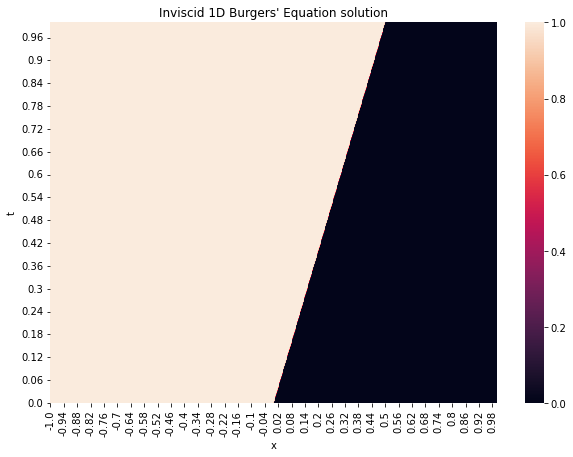

In [30]:
# Plot 2D heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Set up meshgrid
tspace = np.linspace(t_i, t_f, nt)
xspace = np.linspace(x_i, x_f, nx)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Plot 2D heatmap
plt.figure(figsize = (10, 7))
ax = sns.heatmap(u_evolved)
ax.set_xticks(range(0, xspace.shape[0], 30))
ax.set_xticklabels([np.round(xspace[i], 2) for i in list(range(0, xspace.shape[0], 30))])
ax.set_yticks(range(0, tspace.shape[0], 30))
ax.set_yticklabels([np.round(tspace[i], 2) for i in list(range(0, tspace.shape[0], 30))])
plt.xlabel("x")
plt.ylabel("t")
plt.title("Inviscid 1D Burgers' Equation solution")
ax.invert_yaxis()
plt.savefig("Images/Numerical_Inviscid_1D_Burgers_Eq__MacCormack_Heatmap.png")
plt.show()

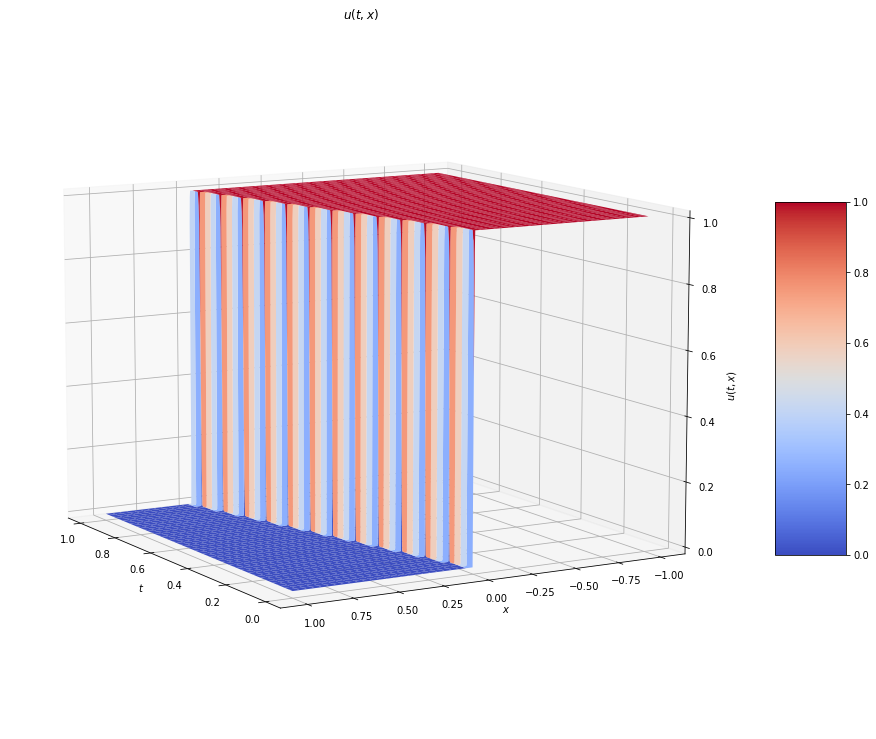

In [31]:
# Plot 3D surface
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(T, X, u_evolved.T, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 150)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('$u(t,x)$')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("Images/Numerical_Inviscid_1D_Burgers_Eq__MacCormack_3D.png")
plt.show()

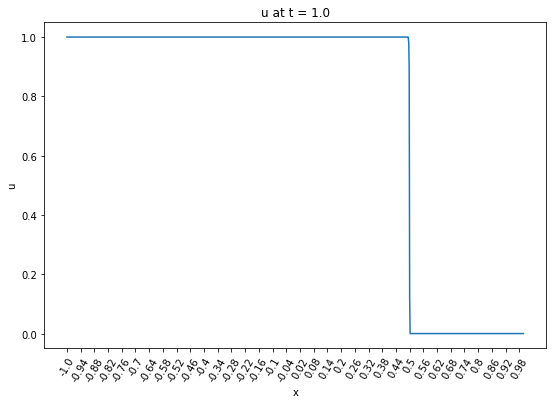

In [34]:
fig = plt.figure(figsize=(9,6))
plt.plot(u_evolved[u_evolved.shape[0]-1,:])
plt.title("u at t = " + str(t_f))
plt.xticks(range(0, xspace.shape[0], 30), labels = [np.round(xspace[i], 2) for i in list(range(0, xspace.shape[0], 30))], rotation = 60)
plt.xlabel("x")
plt.ylabel("u")
plt.savefig("Images/Numerical_Inviscid_1D_Burgers_Eq__MacCormack_final_time.png")
plt.show()

In [35]:
# Save data
import h5py

hf = h5py.File("Models_Data/Numerical_Inviscid_1D_Burgers_Eq__MacCormack.h5", "w")
hf.create_dataset("u_evolved", data = u_evolved)
hf.create_dataset("xspace", data = xspace)
hf.create_dataset("tspace", data = tspace)
hf.close()